This method uses the Okubo–Weiss parameter following the method described in:
[1] https://link.springer.com/content/pdf/10.1007/s10236-013-0680-7.pdf

Limitation:
- noise in the W field
- detects an excess of eddies (Sadarjoenand Post 2000; Chaigneau et al. 2008)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

Read data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
#dataset = 'data10102019'
dataset = "01052014"

f = netcdf_file(dataset+".nc")
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
vel_y = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
#imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)
imputed_vel_x = np.ma.masked_where(np.isnan(vel_x), vel_x)
imputed_vel_y = np.ma.masked_where(np.isnan(vel_y), vel_y)

## Compute the Okubo-Weiss parameter

<IPython.core.display.Javascript object>


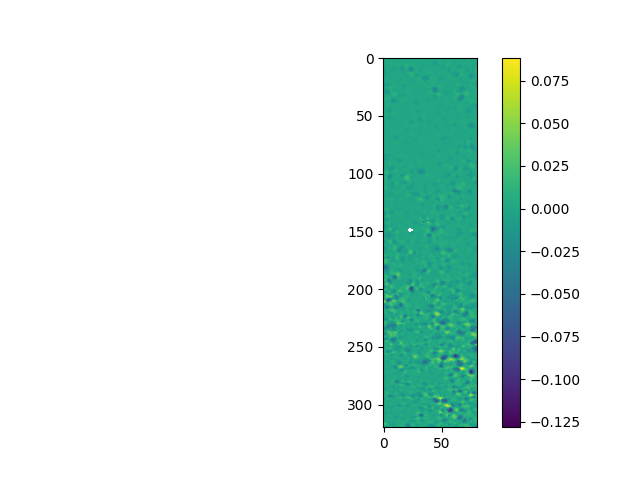

In [3]:
from common_functions import compute_okubo_weiss_parameter

W = compute_okubo_weiss_parameter(imputed_vel_x, imputed_vel_y)

plt.figure()
plt.imshow(W)
plt.colorbar()

## Compute threshold for an Eddie

Define an Eddie as a region where $W < W_0$. The threshold is defined as $W_0 = -0.2\sigma_W$ where $\sigma_W$ is the spatial standard devation of $W$.

In [4]:
W_0 = -0.2 * np.std(W)
W_0

-0.0020082614627139604

## Threshold data

<IPython.core.display.Javascript object>


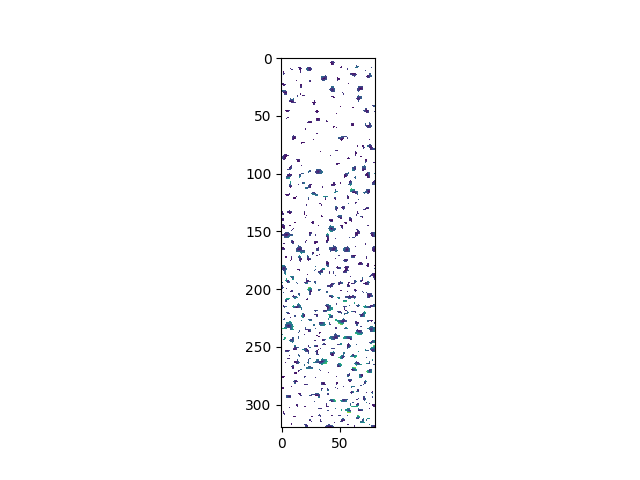

In [5]:
W_eddies = np.ma.masked_where(W > W_0, np.hypot(imputed_vel_x, imputed_vel_y))

plt.figure()
plt.imshow(W_eddies)

<IPython.core.display.Javascript object>


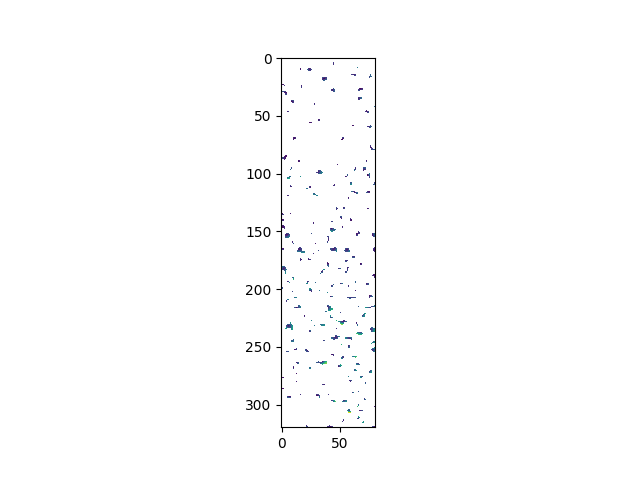

In [6]:
# here we can apply a minimum size citerion just need to decide what
W_eddies = np.ma.where(W < W_0, W, 0)
from scipy import ndimage
W_eddies = ndimage.maximum_filter(W_eddies, size=(2,2))
W_eddies_ma = np.ma.masked_where(W_eddies == 0, np.hypot(imputed_vel_x, imputed_vel_y))
plt.figure()
plt.imshow(W_eddies_ma)

<IPython.core.display.Javascript object>


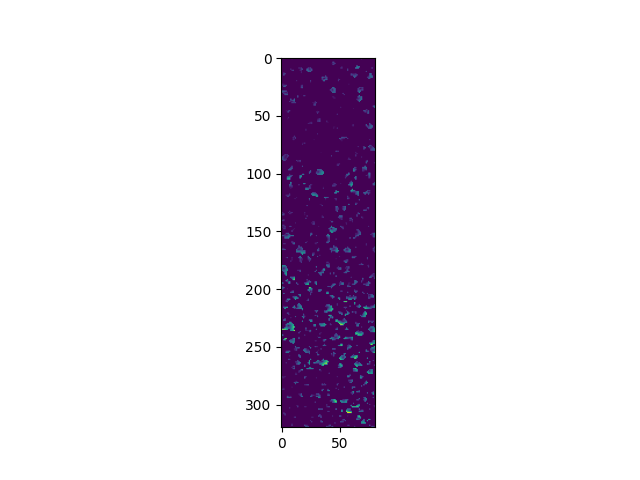

In [7]:
W_eddies = np.where(W_eddies == 0, 0, np.hypot(imputed_vel_x, imputed_vel_y))
plt.figure()
plt.imshow(W_eddies)

In [8]:
from scipy.ndimage import label
labels, numL = label(W_eddies)
eddies = []
for i in range(1, numL+1):
    eddies.append(np.mean(np.argwhere(labels == i),axis=0))
eddies = np.asarray(eddies)

In [15]:
from scipy.interpolate import RegularGridInterpolator

m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

latm, longm = np.meshgrid(lat, long, indexing='ij')

interp_lat = RegularGridInterpolator((i, j), latm, method=method)
interp_long = RegularGridInterpolator((i, j), longm, method=method)

np.savetxt(f"ow-{dataset}.csv",np.column_stack([interp_lat(eddies), interp_long(eddies)]), delimiter=',')

In [10]:
eddies

array([[5.00000000e-01, 2.00000000e+00],
       [3.33333333e-01, 9.33333333e+00],
       [0.00000000e+00, 4.75000000e+01],
       [0.00000000e+00, 5.45000000e+01],
       [1.66666667e-01, 6.98333333e+01],
       [5.00000000e+00, 4.45000000e+01],
       [8.28571429e+00, 6.54285714e+01],
       [8.66666667e+00, 5.16666667e+01],
       [1.04000000e+01, 1.66000000e+01],
       [1.05000000e+01, 2.40000000e+01],
       [9.00000000e+00, 7.80000000e+01],
       [1.00000000e+01, 8.00000000e+00],
       [1.05000000e+01, 5.70000000e+01],
       [1.10000000e+01, 9.50000000e+00],
       [1.20000000e+01, 7.30000000e+01],
       [1.40000000e+01, 2.25000000e+00],
       [1.50000000e+01, 6.24666667e+01],
       [1.62000000e+01, 7.62000000e+01],
       [1.81111111e+01, 3.70000000e+01],
       [1.90000000e+01, 4.92500000e+01],
       [2.00000000e+01, 1.30000000e+01],
       [2.05000000e+01, 2.50000000e+01],
       [2.39000000e+01, 1.80000000e+00],
       [2.30000000e+01, 5.80000000e+01],
       [2.500000